In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import random
from torch.utils.data import Dataset,sampler,DataLoader
import torch
import torch.nn as nn

In [2]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

In [264]:
train=series[:50]

In [265]:
test=series

In [266]:
class sequence_labeling_dataset(Dataset):
    
    def __init__(self, input,max_size=100,sequence_labeling=True,seasonality=12):     
        
        self.data=input
        self.max_size=max_size
        self.sequence_labeling=sequence_labeling
        self.seasonality=seasonality

    def __len__(self):
        
        return int(len(self.data))
    
    def __getitem__(self, index):
        
        data_i=self.data

        inp=np.array(data_i[:-12])
        
        out=np.array(data_i[-12:])
        
        return inp, out,0
    

In [318]:
#Dataset with random shuffeling: We have to check, that seasonality gets shifted apropriatly 
class sequence_labeling_dataset(Dataset):
    
    def __init__(self, input,max_size=100,sequence_labeling=True,seasonality=12,rshift=True):     
        
        self.data=input
        self.max_size=max_size
        self.sequence_labeling=sequence_labeling
        self.seasonality=seasonality
        self.rshift=rshift

    def __len__(self):
        
        return int(len(self.data))
    
    def __getitem__(self, index):
        
        data_i=self.data
        
        if len(data_i)>self.max_size:
            max_rand_int=len(data_i)-self.max_size
            #take a random start integer
            start_int=random.randint(0,max_rand_int)
            #if self.rshift==True: 
            #    start_int=random.randint(0,6)
            #else:
            #    start_int=random.randint(0,6)
                
            #start_int=6
            #return the random chunk of our data 
            data_i=data_i[start_int:(start_int+self.max_size)]
        else:
            start_int=0
            
        #Lets try to forecast one whole seasonality 
        #should be all but the last as the input 
        inp=np.array(data_i[:-self.seasonality])
        
        #This is Sequence Classification
        if self.sequence_labeling==True:
            #this is sequence labeling
            out=np.array(data_i[1:])
        else:
            out=np.array(data_i[-self.seasonality:])
            

        #k=int((init_shift-1)/self.seasonality)
        #shift_steps=self.seasonality+init_shift-self.seasonality*(k+1)
        shift_steps=start_int%self.seasonality
        
        return inp, out,shift_steps
    

In [390]:
sl=sequence_labeling_dataset(train,48,False)
train_dl= DataLoader(dataset=sl,
                      batch_size=1024,
                      shuffle=False
                      )
#We evaluate in sequence classification mode(its the only true forecast )
sl_t=sequence_labeling_dataset(test,1000,False,rshift=False)
test_dl= DataLoader(dataset=sl_t,
                      batch_size=512,
                      shuffle=False

                      )


In [391]:
class holt_winters(torch.nn.Module):
    
    def __init__(self,init_a=0.1,init_b=0.1,init_g=0.1,init_t=0.1,slen=12):
      
        super(holt_winters, self).__init__()
        
        self.alpha=torch.nn.Parameter(torch.tensor(init_a))
        self.beta=torch.nn.Parameter(torch.tensor(init_b))
        self.gamma=torch.nn.Parameter(torch.tensor(init_g))
        
        self.init_season=torch.nn.Parameter(torch.tensor(np.random.random(size=slen)))
        self.init_trend=torch.nn.Parameter(torch.tensor(init_t))
        self.slen=slen
        self.sig=nn.Sigmoid()
        
    def forward(self,series ,n_preds,series_shifts,rv=False):
        
        batch_size=series.shape[0]
        init_season_batch=self.init_season.repeat(batch_size).view(batch_size,-1)
        #seasonals=init_season_batch.float()
        #align for different random shifts in the input (later for different series)
        seasonals=torch.stack([torch.roll(j,int(rol)) for j,rol in zip(init_season_batch,series_shifts)]).float()
        #we have to work with ists, so pytorch can keeo track of the chagnes ( in place changes of tensors not alllowed)
        seasonals=list(torch.split(seasonals,1,dim=1))

        #seasonals=[x.view(x.shape[0]) for x in seasonals]
        seasonals=[x.squeeze() for x in seasonals]

        result = []

        for i in range(series.shape[1]+n_preds):

            if i == 0: 

                smooth = series[:,0]
                trend = self.init_trend.repeat(batch_size)

                result.append(series[:,0])

                continue

            #smoothing
            if i <series.shape[1]:

                val = series[:,i]

                last_smooth, smooth = smooth, self.sig(self.alpha)*(val-seasonals[i%self.slen]) + (1-self.sig(self.alpha))*(smooth+trend)

                trend = self.sig(self.beta) * (smooth-last_smooth) + (1-self.sig(self.beta))*trend
                seasonals[i%self.slen] = self.sig(self.gamma)*(val-smooth) + (1-self.sig(self.gamma))*seasonals[i%self.slen]

                result.append(smooth+trend+seasonals[i%self.slen])

            else:

                m = i - len(series) + 1
                result.append((smooth + m*trend) + seasonals[i%self.slen])
        if rv==False:
            return torch.stack(result,dim=1)
        else:
            return torch.stack(result,dim=1),smooth,trend,seasonals
                

In [392]:
hw=holt_winters().cuda()

In [393]:
opti = torch.optim.Adam(hw.parameters(), lr=0.01)#,weight_decay=0.0001

In [394]:
loss_list=[]


In [397]:
for j in range(500):
    for batch in iter(train_dl):

        opti.zero_grad()
        inp=batch[0].float().cuda()#.unsqueeze(2)
        out=batch[1].float().cuda()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        #it returns the whole sequence atm 
        pred=hw(inp,12,shifts)[:,-12:]
        loss=torch.mean(torch.abs(pred-out))
        loss.backward()
        opti.step()
        if loss < 0.5:
            break
            
    for batch in iter(test_dl):
        opti.zero_grad()
        inp=batch[0].float().cuda()#.unsqueeze(2)
        out=batch[1].float().cuda()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        pred=hw(inp,12,shifts)[:,-12:]
        loss=torch.mean(torch.abs(pred-out))
        loss_list.append(loss.detach().cpu().numpy())
        print(loss)
    

tensor(2.7155, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7108, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7062, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7019, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6979, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6941, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6903, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6866, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6829, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6795, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6760, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6727, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6693, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6661, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6628, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6602, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6588, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.6574, device='cuda:0',

tensor(2.7258, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7267, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7276, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7285, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7294, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7303, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7312, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7322, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7331, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7340, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7349, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7358, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7365, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7374, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7385, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7393, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7398, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7401, device='cuda:0',

tensor(2.7710, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7708, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7707, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7706, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7706, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7707, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7708, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7709, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7709, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7707, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7706, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7703, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7700, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7697, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7692, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7687, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7680, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7673, device='cuda:0',

tensor(2.7638, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7641, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7646, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7650, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7654, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7656, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7657, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7657, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7660, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7665, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7672, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7678, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7679, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7677, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7674, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7674, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7677, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.7683, device='cuda:0',

In [398]:
hw=hw.cpu()

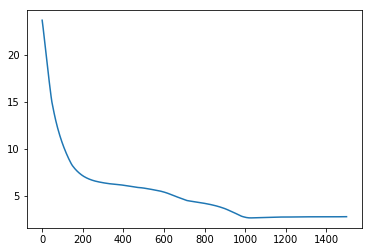

In [399]:
plt.plot(loss_list)

In [400]:
batch =  next(iter(test_dl))

In [413]:
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
#it returns the whole sequence atm 
pred=hw(inp,48,shifts)#[:,-12:]
#loss=torch.mean(torch.abs(pred-out))

In [414]:
pred=pred.detach().numpy()

In [415]:
out=out.detach().numpy()
inp=inp.detach().numpy()

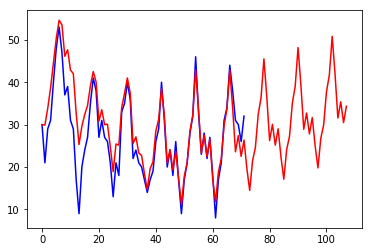

In [416]:
plt.plot(np.concatenate([inp[0,:],out[0,:]]),"b")
plt.plot(pred[0,:],"r")


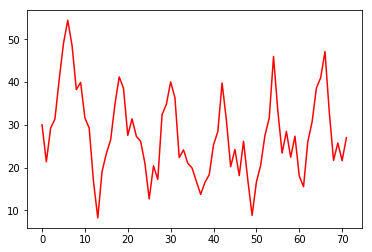

In [379]:
plt.plot(pred[0,:],"r")


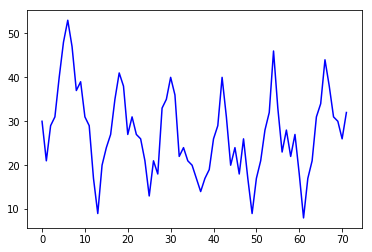

In [380]:
plt.plot(np.concatenate([inp[0,:],out[0,:]]),"b")

In [381]:
plt.plot(np.squeeze(inp.numpy()), 'g') # plotting t, c separately 
plt.plot(np.squeeze(pred), 'b') # plotting t, c separately 
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

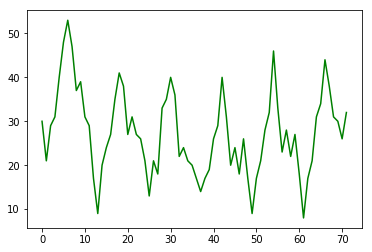

In [299]:
plt.plot(np.concatenate([np.squeeze(inp),np.squeeze(out)]), 'g') # plotting t, c separately 
plt.show()

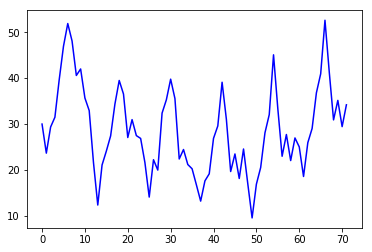

In [300]:
plt.plot(np.squeeze(pred), 'b') # plotting t, c separately 


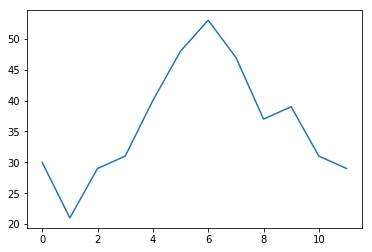

In [235]:
plt.plot(series[0:12])

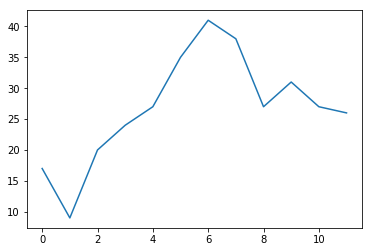

In [236]:
plt.plot(series[12:24])

In [237]:
len(series[12:24])

12

In [238]:
out.shape

(1, 12)

In [239]:
pred.shape

(1, 56)

In [240]:
params=[]
for param in hw.parameters():
    params.append(param)

In [241]:
params

[Parameter containing:
 tensor(-1.2649, requires_grad=True), Parameter containing:
 tensor(-2.8778, requires_grad=True), Parameter containing:
 tensor(1.0469, requires_grad=True), Parameter containing:
 tensor([-0.5125, -0.2710,  3.0907,  0.9330, -1.3761,  1.9721, -0.7254, -1.5417,
         -0.0654,  0.0542, -0.3144,  0.7884], dtype=torch.float64,
        requires_grad=True), Parameter containing:
 tensor(1.9118, requires_grad=True)]

In [242]:
len(params[3].detach().numpy())

12

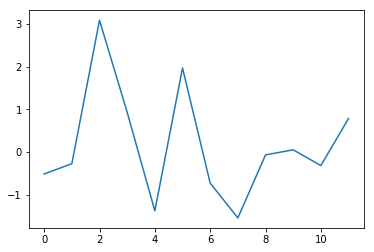

In [243]:
plt.plot(params[3].detach().numpy())

In [261]:
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
#it returns the whole sequence atm 
pred=hw(inp,48,shifts,True)#[:,-12:]
#loss=torch.mean(torch.abs(pred-out))

In [262]:
preds=pred[0][:,-48:]
level=pred[1]
trend=pred[2]
season=pred[3]

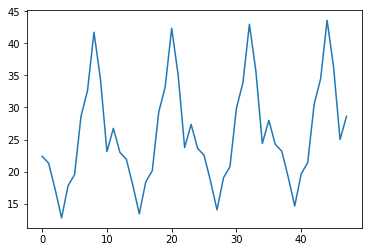

In [263]:
plt.plot(preds.detach().squeeze().numpy())

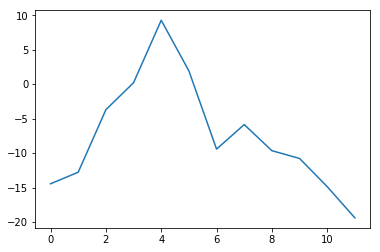

In [251]:
plt.plot(torch.stack(season).detach().squeeze().numpy())

In [253]:
level

tensor([29.7583], grad_fn=<AddBackward0>)

In [252]:
trend

tensor([0.0519], grad_fn=<AddBackward0>)

In [ ]:
plt.plot(params[3].detach().numpy())

In [ ]:
plt.plot(params[3].detach().numpy())

In [ ]:
plt.plot(params[3].detach().numpy())

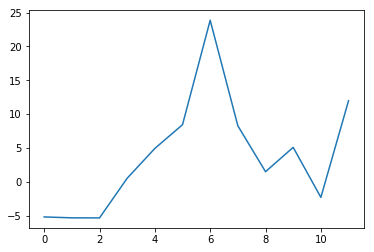

In [329]:
#THe init season it learns with no shifi 
plt.plot(params[3].detach().numpy())